In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import fft
from matplotlib.colors import LogNorm

# Part 1: Newton's method fit

With the assumption that the noise in the map is uniform and uncorrelated between map pixels, I performed the fit using Newton's method. The model I tried to fit was given by 

$$d = A \times e^{-0.5r/\sigma^2} + c$$

Where $A$ was the amplitude, $r$ represented a vector from the center of the patch to the center of the source, $\sigma$ is the width of the gaussian, and $c$ is a shift to aid in the fitting of the gaussian to the data patch.

After performing the fit, the best fit values found for the relevant parameters were:

$$A = -187.9$$
$$\sigma = 4.997$$
$$dx = -1.417 \longrightarrow x = 48.58$$
$$dy = -2.684 \longrightarrow y = 47.32$$

Looking at the figure below, we see that even though this fit is not perfect, the residuals show it did a pretty good job in modelling the cluster in the center.  

In [2]:
hdul = fits.open('./advact_tt_patch.fits')
m = hdul[0].data
hdul.close()
m = np.asarray(m, dtype='float')

In [3]:
def mygauss(pars, width):
    vec = np.asarray(np.arange(-width,width),dtype='float')
    amp=pars[0]
    dx=pars[1]
    dy=pars[2]
    sig=pars[3]
    shift = pars[4]                             

    xvec=vec-dx
    yvec=vec-dy
    xmat=np.outer(xvec,np.ones(len(xvec)))
    ymat=np.outer(np.ones(len(yvec)),yvec)
    rmat=xmat**2+ymat**2
    model=np.exp(-0.5*(rmat/sig**2))*amp + shift

    return model

def get_model_derivs(fun,pars,dpar,width):
    model=fun(pars,width)
    npar=len(pars)
    derivs=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pars[i]+dpar[i]
        m_plus=fun(pp,width)
        pp[i]=pars[i]-dpar[i]
        m_minus=fun(pp,width)
        derivs[i]=(m_plus-m_minus)/(2*dpar[i])
    return model,derivs

def get_model_derivs_ravel(fun,pars,dpar,width):
    model,derivs=get_model_derivs(fun,pars,dpar,width)
    model=np.ravel(model)
    npar=len(pars)
    derivs_out=np.empty([len(model),len(pars)])
    for i in range(npar):
        derivs_out[:,i]=np.ravel(derivs[i])
    return model,derivs_out

def newton(pars,data,fun,width,dpar,niter=30):
    for i in range(niter):
        model,derivs=get_model_derivs_ravel(fun,pars,dpar,width)
        resid=data-model
        lhs=derivs.T@derivs
        rhs=derivs.T@resid
        shift=np.linalg.inv(lhs)@rhs
        pars=pars+shift
    return pars

In [4]:
width = 50
x0 = 2000
y0 = 3000
dx = 0
dy = -2
sig = 3
amp = -200
shift=1
patch = m[x0-width:x0+width,y0-width:y0+width]

pars=np.asarray([amp, dx, dy, sig, shift], dtype='float')
dpar=np.asarray([1.0,0.01,0.01,0.01,0.01])/1000

In [5]:
fitp = newton(pars, np.ravel(patch), mygauss, width, dpar)
mymod = mygauss(fitp, width)
res = patch - mymod

In [6]:
print('The best fit positions are dx = {}, dy = {}'.format(fitp[1], fitp[2]))
print('The best fit sigma is sig = {}'.format(fitp[3]))
print('The best fit amplitude is a = {}'.format(fitp[0]))

The best fit positions are dx = -1.4174519130075198, dy = -2.683552942730242
The best fit sigma is sig = 4.996820583733303
The best fit amplitude is a = -187.86257785708096


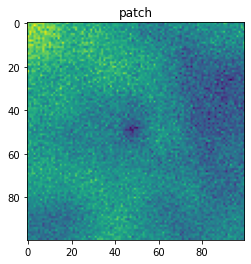

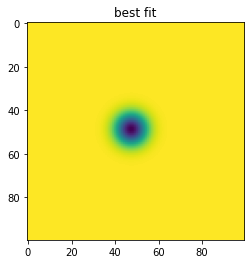

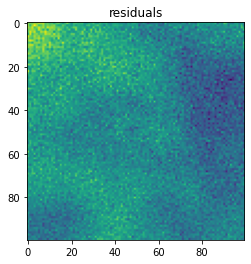

In [7]:
plt.imshow(patch)
plt.title('patch')
plt.show()
plt.imshow(mymod)
plt.title('best fit')
plt.show()
plt.imshow(res)
plt.title('residuals')
plt.show()

# Part 2: Power Spectrum

For this part, I estimated the power spectrum of the map by taking the fourier transform of the map and squaring it. Then, using a gaussian kernel, I smoothed that 2D power spectrum using the $\sigma$ found with the best fit from part 1. I made sure to pad the map before performing any fourier transforms to keep the edges from having any discontinuities. 

Below, I show a plot of the resulting power spectrum and the power spectrum after shifting it to move the edges onto the center. Note that the resulting power spectrum comes from the padded map, so it has dimensions to match with that. 

In [8]:
def pad_map(map):
    map=np.hstack([map,np.fliplr(map)])
    map=np.vstack([map,np.flipud(map)])
    return map

In [9]:
def get_gauss_kernel(m, sig,norm=False):
    nx=m.shape[0]
    x=np.fft.fftfreq(m.shape[0])*m.shape[0]
    y=np.fft.fftfreq(m.shape[1])*m.shape[1]
    rsqr=np.outer(x**2,np.ones(m.shape[1]))+np.outer(np.ones(m.shape[0]),y**2)
    kernel=np.exp((-0.5/sig**2)*rsqr)
    if norm:
        kernel=kernel/kernel.sum()
    return kernel

In [10]:
def estimate_ps(m, sig):
    '''takes the 2D power spectrum of the map
    Returns a padded power spectrum'''
    
    m_pad = pad_map(m)
    
    mapft = fft.fft2(m_pad, workers=4)                 # getting FT of map
    mapft2 = np.abs(mapft)**2                          # absolute value squared
    kernel = get_gauss_kernel(m_pad, sig, norm=True)   # gaussian kernel of width sig
    map_temp = fft.fft2(mapft2, workers=4)             # ft of the map ft squared
    kernelft = fft.fft2(kernel, workers=4)             # ft of kernel
    smooth = map_temp * kernelft                       # convolving
    ps = fft.ifft2(smooth, workers=4)                  # inverse ft
    
    return ps

In [11]:
# using the sigma from the best fit
ps = estimate_ps(m, fitp[3])

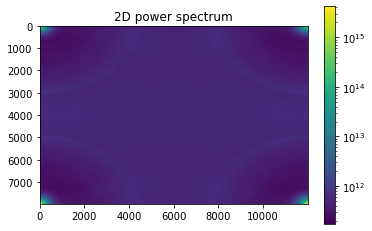

In [12]:
plt.imshow(np.real(ps), norm=LogNorm())
plt.colorbar()
plt.title('2D power spectrum')
plt.show()

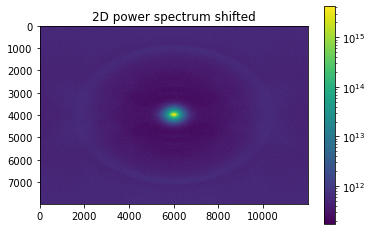

In [13]:
plt.imshow(np.real(fft.fftshift(ps)[1:,1:]), norm=LogNorm())
plt.colorbar()
plt.title('2D power spectrum shifted')
plt.show()

# Part 3: Noise-Filtering

For the noise filtering, the purpose is to convert the noise in our map into uncorrelated noise and in order to do that, we use the power spectrum to contruct a noise matrix and apply that matrix to our map. 

Looking at the results from running the map through this function, we see that the initial map initially had very highly correlated noise around the cluster but had uncorrelated white noise afterwards. Plotting both of the maps (before and after filtering) on the same colorbar scale, it looks like the signal of the cluster source was not greatly reduced or increased by the filtering, and so I expect the normalization to be correct  Of course, this will be checked in part 4. 

In [14]:
def filter_map(m, ps):
    '''Inputs:
    m = non-padded map
    ps = padded power spectrum
    
    Outputs:
    m_filt = noise-filtered non-padded map
    '''
    m_pad = pad_map(m)                                       # padding the map and power spectrum
    norm = (m_pad**2).sum()                                  # normalization factor
    Ninv = (1 / ps) * norm                                   # estimating inverse noise matrix
    mft = fft.fft2(m_pad)                       
    filt_pad = fft.ifft2(mft*Ninv)                           # padded filtered map
    m_filt = np.real(filt_pad[0:m.shape[0], 0:m.shape[1]])   # removing padding
    
    return m_filt 

In [15]:
m_filt = filter_map(m, ps)

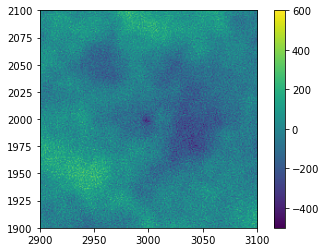

In [16]:
plt.imshow(m, vmax=600, vmin=-500)
plt.xlim(2900, 3100)
plt.ylim(1900, 2100)
plt.colorbar()
plt.show()

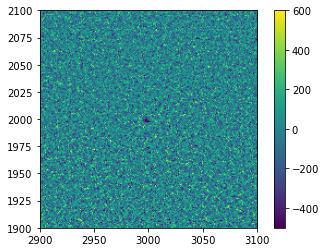

In [17]:
plt.imshow(m_filt, vmax=600, vmin=-500)
plt.xlim(2900, 3100)
plt.ylim(1900, 2100)
plt.colorbar()
plt.show()

# Part 4: Normalization

To make sure the filtering had the correct normalization, I created a map of white noise with mean 0. I tested this for varying standard deviations to check that it would still properly normalize independent of that. One example is given below for a map of white noise with mean 0 and standard deviation of 4. After running the map through the power spectrum estimation and the filtering, the variance recovered was 16, exactly what we would expect. 

In [18]:
# creating map of white noise
wn = np.random.normal(loc=0.0, scale=4.0, size=(100,100))
# getting power spectrum from that 
ps_wn = estimate_ps(wn, 3)
# noise filtering
wn_filt = filter_map(wn, ps_wn)
print('recovered variace is = {}, original variance is = {}'.format(np.var(wn_filt), np.var(wn)))

recovered variace is = 15.63842755126599, original variance is = 15.848567602468043


# Part 5: Matched Filter

In order to make a matched-filter of the ACT data, I first created a template signal consisting of a gaussian signal with the width corresponding to that found in the fit for part 1.

I used the power spectrum estimated previously to find $N^{-1}$ and also performed the noise filtering. Finally, I estimated the right and left hand sides of the equation and from there found the amplitude by taking rhs/lhs. I normalized this by using the sum of the model squared and also divided by four given that we used a paded data and model for these calculations and the original frame was 1/4 of the one used. The resulting amplitude I got was $A = -297.92 \mu K$. This is same order ot magnitude as what I got for the first part, but they do differ by some factor. 

Unfortunately, I didn't have time to continue with the assignment and finish Part 6).

In [19]:
data = pad_map(m)

# making signal we expect to find with sigma from best fit params
x=np.fft.fftfreq(data.shape[0])*data.shape[0]
y=np.fft.fftfreq(data.shape[1])*data.shape[1]
rsqr=np.outer(x**2,np.ones(len(y)))+np.outer(np.ones(len(x)),y**2)
signal=np.exp(-0.5*rsqr/(fitp[3]**2))

In [20]:
# Ninv * signal
Ninv = (1 / ps)
signal_ft = fft.fft2(signal)
Ninv_sig = signal_ft*Ninv

In [21]:
data_ft = fft.fft2(data)
mf_rhs = np.sum(np.real(fft.ifft2(Ninv_sig * np.conj(data_ft))))
mf_lhs = np.sum(np.real(fft.ifft2(Ninv_sig * np.conj(signal_ft))))

In [22]:
amp_temp = np.real(mf_rhs/mf_lhs)
amp_mf = amp_temp/((signal**2).sum())/4
print(amp_mf)

-297.919919759469
